In [1]:
import multiprocessing
import json

import numpy as np
import pandas as pd

# import tensorflow as tf

import ray
from ray import tune
from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG

from matplotlib import pyplot as plt
import seaborn as sns

import gym

n_cpus = multiprocessing.cpu_count()
n_cpus

Instructions for updating:
non-resource variables are not supported in the long term


16

In [2]:
# n_gpus = len(tf.config.list_physical_devices('GPU'))
n_gpus = 0
n_gpus

0

In [3]:
# initialize ray
# https://ray.readthedocs.io/en/latest/package-ref.html#ray.init
ray.init(ignore_reinit_error=True, log_to_driver=False, dashboard_host='0.0.0.0')


2020-11-21 11:36:13,848	INFO services.py:1090 -- View the Ray dashboard at http://192.168.0.23:8265


{'node_ip_address': '192.168.0.23',
 'raylet_ip_address': '192.168.0.23',
 'redis_address': '192.168.0.23:6379',
 'object_store_address': '/tmp/ray/session_2020-11-21_11-36-13_372673_20570/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-11-21_11-36-13_372673_20570/sockets/raylet',
 'webui_url': '192.168.0.23:8265',
 'session_dir': '/tmp/ray/session_2020-11-21_11-36-13_372673_20570',
 'metrics_export_port': 62521,
 'node_id': '73b921d916afb2d08b1816771ddab3069bbb1642'}

In [4]:
# run one training iteration
# https://github.com/ray-project/ray/blob/master/rllib/agents/ppo/ppo.py
env_name = 'CartPole-v1'

ppo_config = DEFAULT_CONFIG.copy()
if n_gpus:
    ppo_config['num_gpus'] = n_gpus
    ppo_config['tf_session_args']['device_count']['GPU'] = n_gpus

ppo_config['num_workers'] = 1
ppo_config['num_sgd_iter'] = 2
ppo_config['sgd_minibatch_size'] = 128
ppo_config['lr'] = 0.0003
ppo_config['gamma'] = 0.99
ppo_config['model']['fcnet_hiddens'] = [64, 64]
ppo_config['timesteps_per_iteration'] = 2000
ppo_config['train_batch_size'] = 8000
ppo_config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed
ppo_config['framework']='tfe'
agent = PPOTrainer(ppo_config, env_name)
result = agent.train()

result

2020-11-21 11:17:52,985	INFO trainer.py:588 -- Executing eagerly, with eager_tracing=False
2020-11-21 11:17:52,986	INFO trainer.py:1064 -- `_use_trajectory_view_api` only supported for PyTorch so far! Will run w/o.
2020-11-21 11:17:52,986	INFO trainer.py:617 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.


{'episode_reward_max': 121.0,
 'episode_reward_min': 8.0,
 'episode_reward_mean': 20.984251968503937,
 'episode_len_mean': 20.984251968503937,
 'episodes_this_iter': 381,
 'policy_reward_min': {},
 'policy_reward_max': {},
 'policy_reward_mean': {},
 'custom_metrics': {},
 'hist_stats': {'episode_reward': [14.0,
   15.0,
   14.0,
   22.0,
   11.0,
   9.0,
   29.0,
   33.0,
   18.0,
   16.0,
   16.0,
   34.0,
   39.0,
   28.0,
   12.0,
   14.0,
   24.0,
   35.0,
   13.0,
   16.0,
   12.0,
   25.0,
   26.0,
   20.0,
   13.0,
   11.0,
   10.0,
   25.0,
   22.0,
   32.0,
   19.0,
   18.0,
   15.0,
   9.0,
   27.0,
   10.0,
   20.0,
   15.0,
   19.0,
   29.0,
   14.0,
   14.0,
   13.0,
   14.0,
   11.0,
   15.0,
   14.0,
   16.0,
   46.0,
   14.0,
   15.0,
   18.0,
   14.0,
   30.0,
   22.0,
   15.0,
   17.0,
   22.0,
   13.0,
   13.0,
   33.0,
   14.0,
   12.0,
   18.0,
   15.0,
   20.0,
   41.0,
   12.0,
   16.0,
   33.0,
   24.0,
   13.0,
   18.0,
   14.0,
   11.0,
   15.0,
   32.0,
   2

In [5]:
# tune hyperparamters with grid search
# https://github.com/ray-project/ray/blob/master/python/ray/tune/tune.py
ray.init(ignore_reinit_error=True)
env_name = 'CartPole-v1'
ppo_config = {
    "env": env_name,
    "num_workers": 1,
    'model': {
        'fcnet_hiddens': tune.grid_search([
                                           [16, 16], [32, 32], [64, 64], [128, 128],
                                          ])
    },        
    'train_batch_size': 1000,
    "lr": tune.grid_search([0.0003, 0.0001]),
    'gamma': tune.grid_search([0.99, 0.999]),
    'framework': 'tfe',
    'num_gpus': n_gpus  
}
                      
analysis = tune.run(
    "PPO",
    name='cartpole_test',
    verbose=1,
    stop={"episode_reward_mean": 300},  # stop when a parameter set is able to reach 300 timesteps
    config = ppo_config,
    checkpoint_freq=10,
    checkpoint_at_end=True,
    checkpoint_score_attr='episode_reward_mean',
    num_samples=1,  # for grid search, number of times to run each hyperparameter combo
    #     with_server=True,
    #     server_port=8267,
)


Trial name,status,loc,gamma,lr,model/fcnet_hiddens,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_268dd_00000,TERMINATED,,0.99,0.0003,"[16, 16]",37,223.382,37000,300.93,500,44,300.93
PPO_CartPole-v1_268dd_00001,TERMINATED,,0.999,0.0003,"[16, 16]",35,209.194,35000,301.4,500,18,301.4
PPO_CartPole-v1_268dd_00002,TERMINATED,,0.99,0.0001,"[16, 16]",39,232.797,39000,301.73,500,26,301.73
PPO_CartPole-v1_268dd_00003,TERMINATED,,0.999,0.0001,"[16, 16]",46,280.03,46000,302.52,500,101,302.52
PPO_CartPole-v1_268dd_00004,TERMINATED,,0.99,0.0003,"[32, 32]",35,214.664,35000,306.52,500,17,306.52
PPO_CartPole-v1_268dd_00005,TERMINATED,,0.999,0.0003,"[32, 32]",35,212.746,35000,307.41,500,42,307.41
PPO_CartPole-v1_268dd_00006,TERMINATED,,0.99,0.0001,"[32, 32]",36,220.485,36000,303.03,500,23,303.03
PPO_CartPole-v1_268dd_00007,TERMINATED,,0.999,0.0001,"[32, 32]",44,273.047,44000,302.42,500,74,302.42
PPO_CartPole-v1_268dd_00008,TERMINATED,,0.99,0.0003,"[64, 64]",33,268.542,33000,311.17,500,22,311.17
PPO_CartPole-v1_268dd_00009,TERMINATED,,0.999,0.0003,"[64, 64]",32,259.593,32000,301.79,500,12,301.79


2020-11-21 11:27:28,357	INFO tune.py:439 -- Total run time: 556.59 seconds (556.31 seconds for the tuning loop).


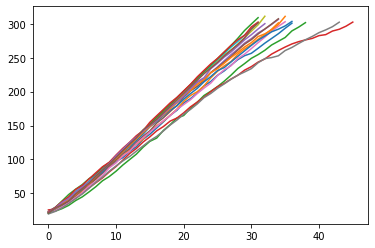

In [6]:
dfs = analysis.trial_dataframes

# Plot by epoch
ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.episode_reward_mean.plot(ax=ax, legend=False)
    

In [7]:
analysis.dataframe().sort_values(['timesteps_total','episode_reward_mean'])[['config/lr', 
                                                                             'config/gamma', 
                                                                             'config/model', 
                                                                             'episode_reward_mean', 
                                                                             'timesteps_total']]


,config/lr,config/gamma,config/model,episode_reward_mean,timesteps_total
15,0.0001,0.999,"{'fcnet_hiddens': [128, 128]}",301.46,32000
9,0.0003,0.999,"{'fcnet_hiddens': [64, 64]}",301.79,32000
13,0.0003,0.999,"{'fcnet_hiddens': [128, 128]}",302.49,32000
12,0.0003,0.990,"{'fcnet_hiddens': [128, 128]}",309.04,32000
14,0.0001,0.990,"{'fcnet_hiddens': [128, 128]}",300.21,33000
8,0.0003,0.990,"{'fcnet_hiddens': [64, 64]}",311.17,33000
1,0.0003,0.999,"{'fcnet_hiddens': [16, 16]}",301.40,35000
4,0.0003,0.990,"{'fcnet_hiddens': [32, 32]}",306.52,35000
5,0.0003,0.999,"{'fcnet_hiddens': [32, 32]}",307.41,35000
6,0.0001,0.990,"{'fcnet_hiddens': [32, 32]}",303.03,36000


In [8]:
analysis.dataframe()[['config/lr', 'timesteps_total']].groupby('config/lr').mean()

,timesteps_total
config/lr,
0.0001,37875
0.0003,33875


In [9]:
analysis.dataframe()[['config/gamma', 'timesteps_total']].groupby('config/gamma').mean()

,timesteps_total
config/gamma,
0.990,35250
0.999,36500


In [10]:
aframe = analysis.dataframe()
aframe['config/model'] = aframe['config/model'].astype(str)
aframe[['config/model', 'timesteps_total']] \
    .groupby(['config/model']) \
    .mean() \
    .sort_values('timesteps_total') \
    .head(10)

,timesteps_total
config/model,
"{'fcnet_hiddens': [128, 128]}",32250
"{'fcnet_hiddens': [64, 64]}",34500
"{'fcnet_hiddens': [32, 32]}",37500
"{'fcnet_hiddens': [16, 16]}",39250


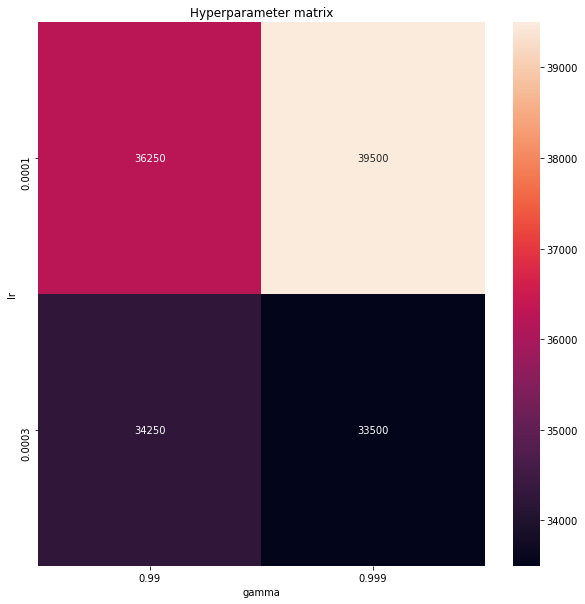

In [11]:
zframe = analysis.dataframe()[['config/lr', 'config/gamma', 'timesteps_total']]
matrix = pd.pivot_table(zframe, 
                        values='timesteps_total', 
                        index=['config/lr'], 
                        columns=['config/gamma'],
                        aggfunc=np.mean)

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(matrix, annot=True, fmt='.0f')
plt.ylabel('lr')
plt.xlabel('gamma')
plt.title("Hyperparameter matrix")
plt.show()

In [12]:
logdir = analysis.get_best_logdir("timesteps_total", mode="min")
logdir

'/Users/drucev/ray_results/cartpole_test/PPO_CartPole-v1_268dd_00009_9_gamma=0.999,lr=0.0003,fcnet_hiddens=[64, 64]_2020-11-21_11-21-55'

In [13]:
with open('%s/params.json' % logdir) as f:
    data = json.load(f)
data

{'env': 'CartPole-v1',
 'framework': 'tfe',
 'gamma': 0.999,
 'lr': 0.0003,
 'model': {'fcnet_hiddens': [64, 64]},
 'num_gpus': 0,
 'num_workers': 1,
 'train_batch_size': 1000}

In [16]:
# train some more, saving checkpoint at end
ray.init(num_cpus=n_cpus, num_gpus=n_gpus, ignore_reinit_error=True, log_to_driver=False, dashboard_host='0.0.0.0')

ppo_config = {
    "env": env_name,
    "num_workers": n_cpus - 1,
    'model': {
        'fcnet_hiddens': [16, 16]
    },        
    'train_batch_size': 10000,
    "lr": 0.0003,
    'gamma': 0.99,
    'num_gpus': n_gpus  
}
                      
analysis = tune.run(
    "PPO",
    name='cartpole_test',
    verbose=1,

    stop={"episode_reward_mean": 500},  # stop when a parameter set is able to reach 500 timesteps
    config = ppo_config,
    checkpoint_freq=10,
    checkpoint_at_end=True,
    checkpoint_score_attr='episode_reward_mean',
    num_samples=1,  # for grid search, number of times to run each hyperparameter combo
    #     with_server=True,
    #     server_port=8267,
)


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_dda4a_00000,TERMINATED,,11,36.2623,132000,500,500,500,500


2020-11-21 11:31:19,811	INFO tune.py:439 -- Total run time: 51.38 seconds (50.71 seconds for the tuning loop).


In [19]:
results_dir = list(analysis.trial_dataframes.keys())[0]
results_dir

'/Users/drucev/ray_results/cartpole_test/PPO_CartPole-v1_dda4a_00000_0_2020-11-21_11-30-28'

In [7]:
# load last checkpoint for the runout
# change this to latest checkpoint
ckpoint = results_dir +  '/checkpoint_11/checkpoint-11'

trainer = PPOTrainer(config=ppo_config, env=env_name)
trainer.restore(ckpoint)


KeyError: '_state'

2020-11-21 11:40:55,268	WARNING worker.py:1091 -- The actor or task with ID ffffffffffffffffbc4ce58d01000000 is pending and cannot currently be scheduled. It requires {CPU: 1.000000} for execution and {CPU: 1.000000} for placement, but this node only has remaining {memory: 10.693359 GiB}, {node:192.168.0.23: 1.000000}, {object_store_memory: 3.662109 GiB}. In total there are 0 pending tasks and 14 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster. You can ignore this message if this Ray cluster is expected to auto-scale.


In [8]:
# view the runout

env = gym.make(env_name)
#env.seed(GLOBAL_SEED)

state = env.reset()
trainer.compute_action(state)

done = False

# run an episode
timestep = 0
r = 0
while not done:
    env.render()
    action = trainer.compute_action(state)
    state, reward, done, _ = env.step(action)
    r += reward
    timestep += 1
print(r)
env.close()
timestep

15.0


15